Agent 구축

In [ ]:
!pip -q install langchain langchain-openai langchain-community duckduckgo-search gradio langgraph langchain-teddynote



In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_teddynote.graphs import visualize_graph

import os

# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata

# api_key=userdata.get('api_key')
# api_key2=userdata.get('api_key2')
# api_key3=userdata.get('api_key3')
# os.environ["OPENAI_API_KEY"] = api_key
# os.environ["LANGCHAIN_API_KEY"] = api_key2
# os.environ["TAVILY_API_KEY"] = api_key3

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")


# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "langgraph_2"


In [30]:
from langchain_teddynote.tools.tavily import TavilySearch
import os

# Set the Tavily API key as an environment variable
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
tool.invoke("랭체인 설명해줘")

[{'url': 'https://www.igloo.co.kr/security-information/%EB%9E%AD%EC%B2%B4%EC%9D%B8langchain-%EA%B7%B8%EA%B2%83%EC%9D%B4-%EC%95%8C%EA%B3%A0-%EC%8B%B6%EB%8B%A4/',
  'title': '랭체인(LangChain), 그것이 알고 싶다 - 이글루코퍼레이션',
  'content': '보다 정확히 말하면 챗GPT가 쏘아올린 대형 언어 모델(Large language model, LLM) 열풍이라고도 할 수 있겠다. 랭체인(LangChain)은 이러한 통합을 간소화하도록 설계된 일종의 SDK(Software Development Kit)이자 다양한 언어 모델을 기반으로 하는 애플리케이션 개발을 위한 프레임워크다. 랭체인의 가장 핵심적인 역할은 그 이름에서 알 수 있듯이 언어 모델(Language model)과 외부 도구를 마치 사슬(Chain)처럼 엮어 결합시켜 주는 데에 있다. 랭체인의 핵심이라고 할 수 있는 언어 모델과의 인터페이스를 지원하는 모델 I/O(Model I/O), 한 모듈의 출력을 다른 모듈의 입력으로 연결하여 여러 구성 요소를 결합할 수 있도록 도와주는 체인(Chain), 특히나 대화형 애플리케이션에는 빼놓을 수 없는, 일정 기간 동안의 과거 메시지를 저장하고 접속할 수 있도록 지원하는 메모리(Memory) 등이 그 예다. 만들고 싶은 애플리케이션이 있지만 각 구성요소를 갖추기 어렵거나, 개발 방법이 복잡하거나, 개발할 시간이 넉넉하지 못할 때 랭체인을 활용하면 비교적 빠르고 간편하게 애플리케이션을 개발할 수 있다.',
  'score': 0.75809944,
  'raw_content': "* **[이벤트]** 우리 조직의 AI 보안 도입 가능성 진단하세요~! 추첨을 통해 **'배달의민족 상품권'**을 드려요! (~9/5)\n\n  [자세히 보기](https://www.igloo.co.kr/newsroom/news/%ec%9d

In [31]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]


In [32]:
from langchain_openai import ChatOpenAI

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


In [33]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용


In [34]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)


In [35]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)


In [36]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()


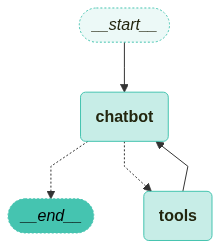

In [37]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)


In [39]:
from langchain_teddynote.messages import display_message_tree

question = "LLM 랭체인"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        display_message_tree(value["messages"][-1])



STEP: chatbot

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_JGuaqtcAIYQg2wcEe91O9AMN"
                function: {"arguments": "{"query":"LLM 랭체인"}", "name": "tavily_web_search"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 22
            prompt_tokens: 97
            total_tokens: 119
            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_e665f7564b"
        id: "chatcmpl-CBx5yIt6yYUNY43HRFynQiBto2Oh8"
        service_tier: "default"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run--f3fe7138-fac3-4cd9-badb-cc6b00f32d76-0"
    example: False
    too

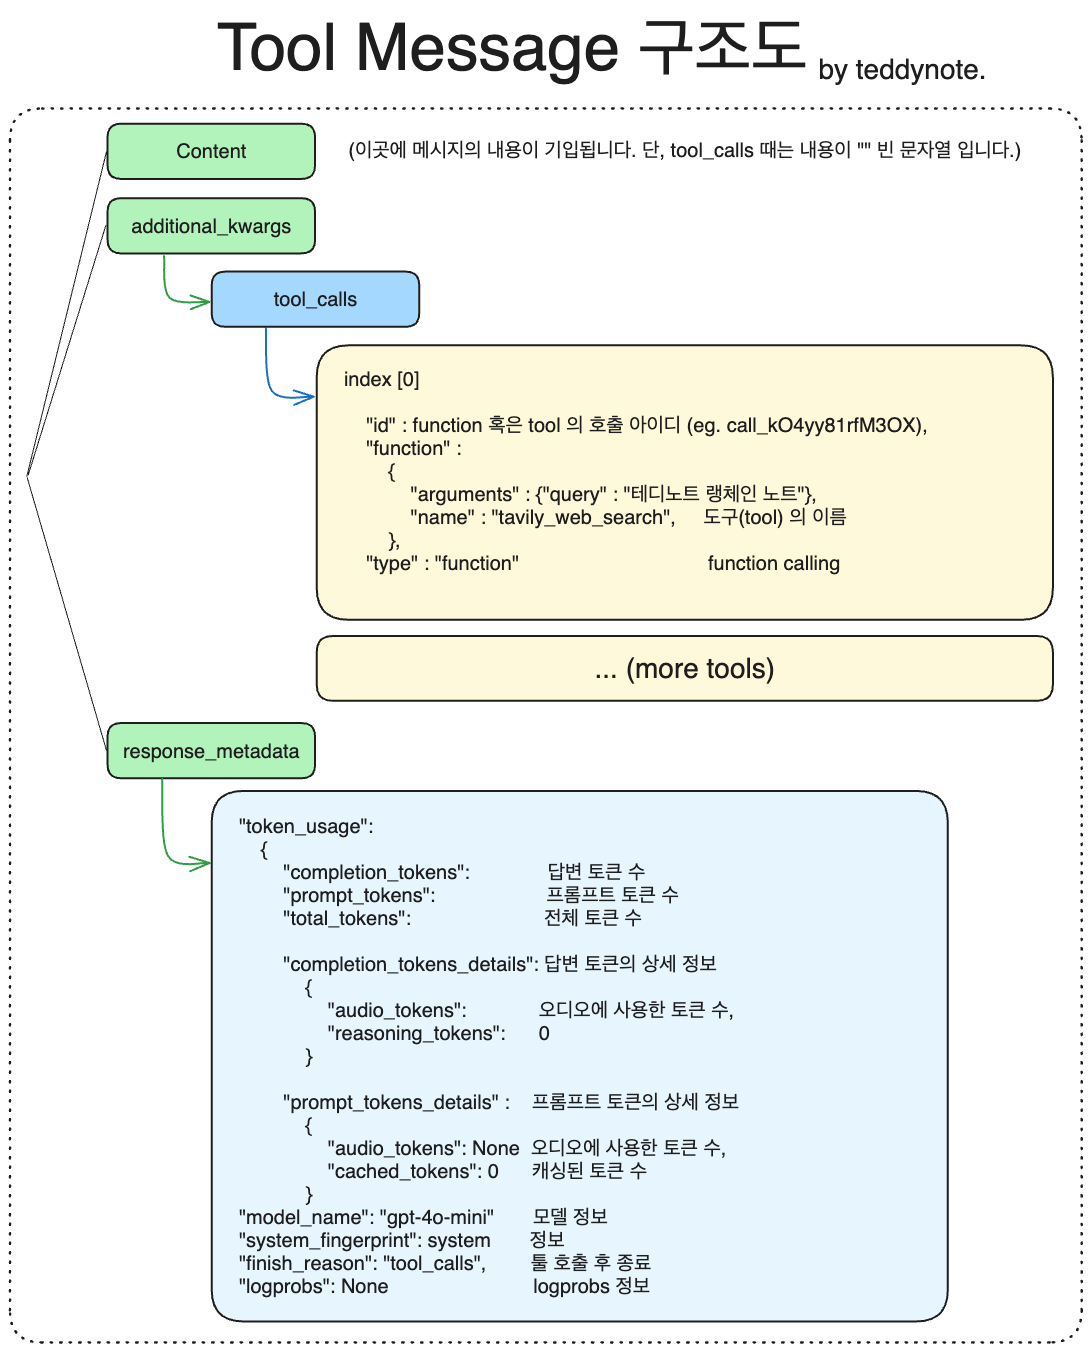